## Handin 2 - Knut Knut Development Model for House Price Prediction

__Institution:__ *University of Agder Campus Grimstad*\
__Course:__ *IKT110 - Artificial Intelligence Architecture*\
__Authors:__ *Cornelius Brandt, Mohammad Itani, Maximilian Eckstein*\
__Date:__ *November 2025*

### Data Preparation and Merging

In this section, we load the data from .jsonl files, merge them based on their relationships, and prepare a columnar data store for further analysis.
In the next section, we clean and encode the data, engineer features, prepare two datasets (for the two models) and split the datasets into training, validation, and test sets.

Regarding missing or wrong data, we handle them by
- Removing records with critical missing values (e.g., missing price or size).
- Inputing mean or median values for numerical features with minor missing data.

In [220]:
import json
import pickle
import re
import numpy as np
from pathlib import Path
from typing import List, Dict, Any, Tuple
import plotly.express as px

# ----- File paths -----
agents_path   = Path("data/agents.jsonl")
districts_path= Path("data/districts.jsonl")
schools_path  = Path("data/schools.jsonl")
houses_path   = Path("data/houses.jsonl")

# ----- Data loading functions -----
def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    with path.open("r", encoding="utf-8") as f:
        return [json.loads(line) for line in f if line.strip()]

def index_by(items: List[Dict[str, Any]], key: str) -> Dict[Any, Dict[str, Any]]:
    return {it[key]: it for it in items if key in it}

# ----- Merging functions (raw data) -----
def merge_all_raw(
    houses: List[Dict[str, Any]],
    districts_by_id: Dict[str, Dict[str, Any]],
    schools_by_id: Dict[str, Dict[str, Any]],
    agents_by_id: Dict[str, Dict[str, Any]],
) -> List[Dict[str, Any]]:
    merged: List[Dict[str, Any]] = []
    for h in houses:
        r = dict(h)  # 1:1 copy

        d = districts_by_id.get(h.get("district_id"))
        if d:
            for k, v in d.items():
                if k != "id":
                    r[f"district_{k}"] = v

        s = schools_by_id.get(h.get("school_id"))
        if s:
            for k, v in s.items():
                if k != "id":
                    r[f"school_{k}"] = v

        a = agents_by_id.get(h.get("agent_id"))
        if a:
            for k, v in a.items():
                if k != "agent_id":
                    r[f"agent_{k}"] = v

        merged.append(r)
    return merged

# ----- Column store conversion -----
def to_column_store(rows: List[Dict[str, Any]]) -> Dict[str, np.ndarray]:
    if not rows:
        return {}
    keys = sorted({k for r in rows for k in r.keys()})
    store: Dict[str, np.ndarray] = {}
    for k in keys:
        store[k] = np.array([r.get(k, None) for r in rows], dtype=object)
    return store

# ----- Helper functions -----
def head(store, n=5):
    """Print the first n records from the column store."""
    keys = list(store.keys())
    for i in range(min(n, len(next(iter(store.values()))))):
        print({k: store[k][i] for k in keys})

def drop_column(store: dict, col_name: str):
    """Remove a column from the column store."""
    if col_name in store:
        del store[col_name]

def add_column(store: dict, col_name_or_dict, values=None):
    """
    Add a new column or multiple columns to the column store.
    - add_column(store, "col", arr)
    - add_column(store, {"col1": arr1, "col2": arr2})
    """
    n = len(next(iter(store.values())))  # Check length

    if isinstance(col_name_or_dict, dict):
        for k, v in col_name_or_dict.items():
            arr = np.array(v)
            if arr.shape[0] != n:
                raise ValueError(f"Length mismatch for {k}: expected {n}, got {arr.shape[0]}")
            store[k] = arr
    else:
        arr = np.array(values)
        if arr.shape[0] != n:
            raise ValueError(f"Length mismatch: expected {n}, got {arr.shape[0]}")
        store[col_name_or_dict] = arr

def rename_column(store: dict, old: str, new: str):
    """Rename a column in the store."""
    if old not in store:
        raise KeyError(f"Column '{old}' does not exist.")
    if new in store:
        raise KeyError(f"Column '{new}' already exists.")
    store[new] = store.pop(old)

def astype_column(store: dict, col: str, dtype):
    """Change the data type of a column."""
    if col not in store:
        raise KeyError(f"Column '{col}' does not exist.")
    try:
        store[col] = store[col].astype(dtype)
    except Exception as e:
        raise TypeError(f"Error converting '{col}' to {dtype}: {e}")

def copy_columns(store, cols, deep=True):
    """Copy selected columns from the store."""
    return {c: np.array(store[c], copy=True) if deep else store[c]
            for c in cols if c in store}

def drop_rows_where(store: dict, col_name: str, condition) -> None:
    """
    Delete rows from all columns where `condition(store[col_name][i])` is True.

    Example:
        drop_rows_where(store, "price", lambda x: x > 1_000_000)
    """
    if col_name not in store:
        raise KeyError(f"Spalte '{col_name}' existiert nicht.")
    col = store[col_name]
    mask = np.array([not condition(x) for x in col])  # True = keep, False = drop
    for k in store.keys():
        store[k] = store[k][mask]

def encode_map(col, mapping, default=np.nan):
    """Map categorical values in `col` using `mapping` dict."""
    out = []
    for v in col:
        key = str(v).strip().lower() if v is not None else ""
        out.append(mapping.get(key, default))
    return np.array(out, dtype=object)

def one_hot_encode(store, col_name: str, prefix=None):
    """One-Hot-Encode a categorical column."""
    col = store[col_name]
    prefix = prefix or col_name
    unique_vals = sorted(set(str(v) for v in col if v is not None))
    out = {}
    for val in unique_vals:
        key = f"{prefix}_{val}"
        out[key] = np.array([(1 if str(v) == val else 0) for v in col], dtype=int)
    # print(out)
    return out

In [221]:
agents    = load_jsonl(agents_path)
districts = load_jsonl(districts_path)
schools   = load_jsonl(schools_path)
houses    = load_jsonl(houses_path)

agents_by    = index_by(agents, "agent_id")
districts_by = index_by(districts, "id")
schools_by   = index_by(schools, "id")

merged_rows = merge_all_raw(houses, districts_by, schools_by, agents_by)
print(f"Merged records: {len(merged_rows)}")

raw_data = to_column_store(merged_rows)
print(f"Columns: {len(raw_data)}")
head(raw_data, n=3)

Merged records: 2552
Columns: 29
{'advertisement': 'premium', 'agent_id': '795dc3219c4548de8a06babe17e5312c', 'agent_name': 'Pedro Sasser', 'bathrooms': 2, 'color': 'white', 'condition_rating': 7, 'days_on_marked': 2.7, 'district_crime_rating': 5, 'district_id': 'f987fd63b94d4a03aafdf4b1a9c71107', 'district_public_transport_rating': 3, 'external_storage_m2': 6, 'fireplace': 'no', 'kitchens': 1, 'lot_w': 0, 'parking': 'no', 'price': 2687103, 'remodeled': 2017, 'rooms': '4 rooms', 'school_built_year': 1979, 'school_capacity': 13, 'school_district_id': 'f987fd63b94d4a03aafdf4b1a9c71107', 'school_id': '8169505b6a3c4799b4b8e0e58565615f', 'school_rating': 1.8, 'size': 55, 'sold': 'yes', 'sold_in_month': 'January', 'storage_rating': 8, 'sun_factor': 0.594, 'year': 2005}
{'advertisement': 'regular', 'agent_id': '48589954489f46239de57d1846b9c79b', 'agent_name': 'Shirley Delrio', 'bathrooms': 3, 'color': 'blue', 'condition_rating': 3, 'days_on_marked': 8.1, 'district_crime_rating': 5, 'district_

In [222]:
# Step 0: Work on a copy of the raw data
df = raw_data.copy()

# Step 1: Drop redundant IDs (already merged data) - "district_id" is used for feature engineering, we drop it later
for c in ["agent_id", "school_id", "school_district_id"]:
    drop_column(df, c)

# Step 2: rooms: "4 rooms" -> 4, empty/misformatted -> np.nan & rename column "days_on_marked"
rooms_raw = df["rooms"]
rooms_num = np.empty(rooms_raw.shape[0], dtype=object)
pat = re.compile("-?\d+")
for i, v in enumerate(rooms_raw):
    s = str(v).strip() if v is not None else ""
    m = pat.search(s)
    rooms_num[i] = float(m.group()) if m else np.nan
add_column(df, "rooms", rooms_num)

rename_column(df, "days_on_marked", "days_on_market")

# Step 3: lot_w: rate 0 as missing value (not possible) -> np.nan
lot = df["lot_w"].astype(object)
lot = np.array([np.nan if (v == 0 or v == "0") else v for v in lot], dtype=object)
add_column(df, "lot_w", lot)

# Step 4: Median imputation (robust) for specific columns ("year", "lot_w", "rooms")
def median_impute(col):
    colf = np.array(
        [np.nan if (v is None or (isinstance(v, str) and v.strip()=='')) else float(v)
         for v in col],
        dtype=float
    )
    med = np.nanmedian(colf)
    colf[np.isnan(colf)] = med
    return colf, med

impute_cols = ["year", "lot_w", "rooms"]
impute_report = {}
for c in impute_cols:
    if c in df:
        colf, med = median_impute(df[c])
        add_column(df, c, colf)
        impute_report[c] = float(med)

# Step 5: remodeled: if -1 -> year (year of construction)
if "remodeled" in df and "year" in df:
    rem = df["remodeled"].astype(float)
    year = df["year"].astype(float)
    # -1 → remove with year of construction
    mask = rem == -1
    rem[mask] = year[mask]
    add_column(df, "remodeled", rem)

# Step 6: binarize: yes/no -> 1/0
for col, mapping in {
    "fireplace": {"yes":1,"no":0,"true":1,"false":0},
    "parking":   {"yes":1,"no":0,"true":1,"false":0},
    "sold":      {"yes":1,"no":0,"true":1,"false":0},
}.items():
    if col in df:
        df[col] = encode_map(df[col], mapping, default=np.nan).astype(np.float32)

# Step 7: One-Hot: advertisement
if "advertisement" in df:
    df.update(one_hot_encode(df, "advertisement", prefix="adv"))
    drop_column(df, "advertisement")

# Step 8: One-Hot: color (with normalization of typing errors)
if "color" in df:
    norm_map = {
        "grey":"gray",
        "reds":"red",
    }
    col = np.array([norm_map.get(str(v).strip().lower(), str(v).strip().lower())
                    if v is not None else "" for v in df["color"]], dtype=object)
    col = np.where(col=="", "<missing>", col)
    add_column(df, "_color_norm", col)
    df.update(one_hot_encode(df, "_color_norm", prefix="color"))
    drop_column(df, "_color_norm")
    drop_column(df, "color")

# Step 9: One-Hot: sold_in_month (fixed categories)
if "sold_in_month" in df:
    months = ["January","February","March","April","May","June",
              "July","August","September","October","November","December"]
    vals = np.array(df["sold_in_month"], dtype=object)
    add_column(df, "_month_norm", vals)
    df.update(one_hot_encode(df, "_month_norm", prefix="month"))
    drop_column(df, "_month_norm")
    drop_column(df, "sold_in_month")

# Step 10: drop rows with price > 1,000,000,000 (outliers)
drop_rows_where(df, "price", lambda x: x > 1_000_000_000)

# Step 11: One-Hot: agent_name
if "agent_name" in df:
    df.update(one_hot_encode(df, "agent_name", prefix="agent"))
    drop_column(df, "agent_name")

# Step 12: Feature engineering (additional features)
# price_per_m2 = price / size
size = df["size"].astype(float)
price = df["price"].astype(float)
pp2 = np.divide(price, size, out=np.full_like(price, np.nan), where=(size>0))
add_column(df, "price_per_m2", pp2)

# age instead of years
current_year = 2025.0
add_column(df, "house_age",  current_year - df["year"])
add_column(df, "school_age", current_year - df["school_built_year"])
add_column(df, "remodel_age", current_year - df["remodeled"])

# price relative to district median
district_ids = df["district_id"]
prices = df["price"].astype(float)

# Compute the median price per district (without pandas)
uniq, inv = np.unique(district_ids, return_inverse=True)   # inv: district index for each row
medians = np.full(uniq.shape[0], np.nan, dtype=float)

for di in range(uniq.shape[0]):
    mask = (inv == di)
    vals = prices[mask]
    medians[di] = np.nanmedian(vals) if mask.any() else np.nan

# Compute price relative to district median
price_rel = np.divide(
    prices,
    medians[inv],
    out=np.full_like(prices, np.nan),
    where=(medians[inv] != 0) & ~np.isnan(medians[inv])
)
add_column(df, "price_relative", price_rel)

# Drop district_id now (optional)
drop_column(df, "district_id")

# Step 13: Convert all columns to float32 where possible
for c, col in df.items():
    try:
        df[c] = df[c].astype(np.float32)
    except Exception:
        # For example, if another string is present (just to be safe)
        pass

# Step 14: z-score normalization (standardization) of selected numerical features
def zscale_inplace(store, cols_to_scale, save_path=None):
    """
    Standardize (z-score) only the given columns in the store and optionally save
    the normalization parameters (mean and std) for each scaled column.
    """
    norm_params = {}

    for k in cols_to_scale:
        # print(k)
        if k not in store:
            continue
        try:
            x = store[k].astype(float)
            mu = np.nanmean(x)
            sd = np.nanstd(x)

            if sd == 0 or np.isnan(sd):
                continue

            store[k] = ((x - mu) / sd).astype(np.float32)
            norm_params[k] = {"mean": mu, "std": sd}

        except Exception:
            pass  # ignore non-numeric or failed conversions

    if save_path is not None:
        with open(save_path, "wb") as f:
            pickle.dump(norm_params, f)

# create normalized data-set
df_norm = df.copy()

# Keep unnormalized target columns
df_norm["prices_not_normalized"] = df["price"].copy()
df_norm["days_on_market_not_normalized"] = df["days_on_market"].copy()

cols_to_scale = [
    # structural
    "bathrooms", "condition_rating", "external_storage_m2", "kitchens",
    "lot_w", "rooms", "size", "storage_rating",
    # age-related
    "school_age", "house_age", "remodel_age",
    # environment / ratings
    "district_crime_rating", "district_public_transport_rating",
    "school_rating", "school_capacity", "sun_factor",
    # price-related (for sold-time)
    "price", "price_relative", "price_per_m2",
    # sold-time
    'days_on_market'
]

zscale_inplace(df_norm, cols_to_scale, "./pickle/parameters.pkl")

print("Dataframe (head) after cleaning and feature engineering:")
head(df, n=3)
print("\nDataframe (head) after normalization:")
head(df_norm, n=3)

Dataframe (head) after cleaning and feature engineering:
{'bathrooms': np.float32(2.0), 'condition_rating': np.float32(7.0), 'district_crime_rating': np.float32(5.0), 'district_public_transport_rating': np.float32(3.0), 'external_storage_m2': np.float32(6.0), 'fireplace': np.float32(0.0), 'kitchens': np.float32(1.0), 'lot_w': np.float32(58.0), 'parking': np.float32(0.0), 'price': np.float32(2687103.0), 'remodeled': np.float32(2017.0), 'rooms': np.float32(4.0), 'school_built_year': np.float32(1979.0), 'school_capacity': np.float32(13.0), 'school_rating': np.float32(1.8), 'size': np.float32(55.0), 'sold': np.float32(1.0), 'storage_rating': np.float32(8.0), 'sun_factor': np.float32(0.594), 'year': np.float32(2005.0), 'days_on_market': np.float32(2.7), 'adv_no': np.float32(0.0), 'adv_premium': np.float32(1.0), 'adv_regular': np.float32(0.0), 'color_black': np.float32(0.0), 'color_blue': np.float32(0.0), 'color_gray': np.float32(0.0), 'color_green': np.float32(0.0), 'color_red': np.float32(

#### Price Model – Selected Features

The following features capture the main physical, qualitative, and locational factors that determine a house’s market value:

| Feature Group | Features | Explanation |
|----------------|-----------|-------------|
| **House Structure & Condition** | `bathrooms`, `condition_rating`, `external_storage_m2`, `kitchens`, `lot_w`, `rooms`, `size`, `storage_rating` | Core structural and quality indicators. Larger, better-equipped houses in good condition generally achieve higher prices. |
| **Age-Related Features** | `school_age`, `house_age`, `remodel_age` | Capture depreciation and modernization effects. Newer or recently renovated homes, or those in newer school districts, tend to sell for higher prices. |
| **Amenities** | `fireplace`, `parking` | Binary indicators for desirable features that directly increase property value. |
| **Location Quality** | `district_crime_rating`, `district_public_transport_rating`, `school_rating`, `school_capacity`, `sun_factor` | Reflect the overall attractiveness of the location, including safety, infrastructure, education, and environmental factors. |
| **Visual Appearance (Colors)** | `color_black`, `color_blue`, `color_gray`, `color_green`, `color_red`, `color_unknown`, `color_white` | Encoded color attributes may capture subtle buyer preferences or design trends. |
| **Excluded Features** | `price_relative`, `price_per_m2`, `price` | These are target-derived or directly dependent on the output variable and would introduce data leakage. |

This feature set balances structural, temporal, and locational influences on house prices while avoiding any leakage or redundant information.

In [223]:
price_features = [
    # House & Condition
    "bathrooms", "condition_rating", "external_storage_m2",
    "kitchens", "lot_w", "size", "rooms", "storage_rating",
    # Age-based
    "school_age", "house_age", "remodel_age",
    # Amenities
    "fireplace", "parking", 
    # Location
    "district_crime_rating","district_public_transport_rating",
    "school_rating","school_capacity", "sun_factor",
    # Colors
    "color_black", "color_blue", "color_gray", "color_green",
    "color_red", "color_unknown", "color_white"
]

with open("./pickle/price_features.pkl", "wb") as f:
    pickle.dump(price_features, f)

#### Sold-Time Model – Selected Features

The following features capture the main factors influencing how quickly a house sells:

| Feature Group | Features | Explanation |
|----------------|-----------|-------------|
| **Price Indicators** | `price`, `price_relative`, `price_per_m2` | Higher or relatively overpriced houses usually stay longer on the market. |
| **Structure & Condition** | `bathrooms`, `condition_rating`, `kitchens`, `lot_w`, `rooms`, `size`, `fireplace`, `parking`, `house_age`, `remodel_age`, `sun_factor` | Describe the overall attractiveness and comfort level of the property. Newer, well-equipped, and renovated homes tend to sell faster. |
| **Location Quality** | `district_crime_rating`, `district_public_transport_rating`, `school_rating`, `school_capacity` | Reflect the neighborhood’s appeal, safety, and accessibility — key factors for buyer interest. |
| **Marketing / Exposure** | `adv_no`, `adv_premium`, `adv_regular` | Marketing strategy and ad quality can influence visibility and sales speed. |
| **Seasonality** | `month_January` … `month_December` | Captures seasonal trends in buyer demand and market activity. |
| **Agent Performance** | `agent_*` one-hot features | Represent different agent efficiencies — some agents may consistently close deals faster. |

Excluded features such as color or school age were omitted due to weak or indirect correlation with sale duration.

In [224]:
soldtime_features = [
    # Price signals
    "price", "price_relative", "price_per_m2"
    # Structure & condition
    "bathrooms", "condition_rating", "kitchens", "lot_w",
    "rooms", "size", "fireplace", "parking",
    "house_age", "remodel_age", "sun_factor",
    # Location
    "district_crime_rating", "district_public_transport_rating",
    "school_rating", "school_capacity",
    # Marketing
    "adv_no", "adv_premium", "adv_regular",
    # Month (one-hots)
    "month_January", "month_February", "month_March", "month_April", "month_May", "month_June",
    "month_July", "month_August", "month_September", "month_October", "month_November", "month_December",
    # Agents (one-hots)
    "agent_Alice Vadasy", "agent_Ann Perez", "agent_Charlotte Nodine", "agent_Cheryl Dunlap", 
    "agent_Donald Campbell", "agent_Donna Mcclintock", "agent_Frank Scheetz", "agent_Frank Schmidt",
    "agent_Gonzalo Ramos", "agent_Gregory Dixon", "agent_John Jimenez", "agent_John Rios", 
    "agent_Johnnie Stanley", "agent_Kirsten Webb", "agent_Lucy Moffatt", "agent_Mary Chavez", 
    "agent_Michael Hanners", "agent_Michael Rowland", "agent_Misty Wallace", "agent_Pat Daniels", 
    "agent_Pedro Sasser", "agent_Porfirio Wueste", "agent_Rhonda Bowers", "agent_Shirley Delrio" 
]

with open("./pickle/soldtime_features.pkl", "wb") as f:
    pickle.dump(soldtime_features, f)

In [225]:
# ----- Helper functions -----
def select_existing(store, cols):
    """Return only columns that actually exist in the store."""
    return [c for c in cols if c in store]

def build_xy(store, feature_cols, target_col):
    """
    Build feature (X) and target (y) arrays from a column-store dictionary.
    Returns:
        X : np.ndarray, shape (n_samples, n_features)
        y : np.ndarray, shape (n_samples,)
        feats : list[str] (used feature names)
    """
    feats = select_existing(store, feature_cols)
    if not feats:
        raise ValueError("No valid features found in the store for this list.")
    X = np.column_stack([store[c].astype(np.float32) for c in feats]).astype(np.float32)
    if target_col not in store:
        # small guard in case of naming mismatch
        alt = "days_on_marked"
        if target_col == "days_on_market" and alt in store:
            target_col = alt
        else:
            raise KeyError(f"Target column '{target_col}' not found in store.")
    y = store[target_col].astype(np.float32)
    return X, y, feats

# ----- Manual split (NumPy) -----
def split_xy_manual(X, y, test_size=0.20, val_size=0.20, seed=42, shuffle=True):
    """
    Split X, y into train/val/test using NumPy only.
    - test_size: fraction of all samples reserved for test
    - val_size:  fraction of all samples reserved for validation
    Final proportions: train = 1 - test_size - val_size
    """
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)

    n_test = int(round(n * test_size))
    n_val  = int(round(n * val_size))
    n_train = n - n_test - n_val
    if n_train <= 0:
        raise ValueError("Not enough samples for the requested split sizes.")

    test_idx  = idx[:n_test]
    val_idx   = idx[n_test:n_test + n_val]
    train_idx = idx[n_test + n_val:]

    return {
        "X_train": X[train_idx], "y_train": y[train_idx],
        "X_val":   X[val_idx],   "y_val":   y[val_idx],
        "X_test":  X[test_idx],  "y_test":  y[test_idx],
        "idx": {"train": train_idx, "val": val_idx, "test": test_idx}
    }

def show_shapes(name, spl):
    print(f"{name}: train {spl['X_train'].shape}, val {spl['X_val'].shape}, test {spl['X_test'].shape}")


# ----- RAW datasets (df) -----
X_price_raw, y_price, price_feats_used = build_xy(df, price_features, "price")
X_days_raw,  y_days,  days_feats_used  = build_xy(df, soldtime_features, "days_on_market")

# ----- STANDARDIZED datasets (df_norm) -----
X_price_std, y_price_std, price_feats_used_std = build_xy(df_norm, price_features, "price")
X_days_std,  y_days_std,  days_feats_used_std  = build_xy(df_norm, soldtime_features, "days_on_market")

# ----- Create splits (manual) -----
spl_price_raw = split_xy_manual(X_price_raw, y_price, test_size=0.30, val_size=0.0, seed=42, shuffle=True)
spl_price_std = split_xy_manual(X_price_std, y_price_std, test_size=0.30, val_size=0.0, seed=42, shuffle=True)
spl_days_raw  = split_xy_manual(X_days_raw,  y_days,  test_size=0.20, val_size=0.0, seed=42, shuffle=True)
spl_days_std  = split_xy_manual(X_days_std,  y_days_std,  test_size=0.20, val_size=0.0, seed=42, shuffle=True)

# ----- Shapes overview -----
print("Price RAW  -> X:", X_price_raw.shape, " y:", y_price.shape,  "| features:", len(price_feats_used))
print("Price STD  -> X:", X_price_std.shape, " y:", y_price_std.shape, "| features:", len(price_feats_used_std))
print("Days  RAW  -> X:", X_days_raw.shape,  " y:", y_days.shape,   "| features:", len(days_feats_used))
print("Days  STD  -> X:", X_days_std.shape,  " y:", y_days_std.shape,  "| features:", len(days_feats_used_std))

show_shapes("PRICE raw", spl_price_raw)
show_shapes("PRICE std", spl_price_std)
show_shapes("DAYS  raw",  spl_days_raw)
show_shapes("DAYS  std",  spl_days_std)

print(spl_price_raw["X_train"].shape)

Price RAW  -> X: (2550, 25)  y: (2550,) | features: 25
Price STD  -> X: (2550, 25)  y: (2550,) | features: 25
Days  RAW  -> X: (2550, 55)  y: (2550,) | features: 55
Days  STD  -> X: (2550, 55)  y: (2550,) | features: 55
PRICE raw: train (1785, 25), val (0, 25), test (765, 25)
PRICE std: train (1785, 25), val (0, 25), test (765, 25)
DAYS  raw: train (2040, 55), val (0, 55), test (510, 55)
DAYS  std: train (2040, 55), val (0, 55), test (510, 55)
(1785, 25)


# Model 

In [226]:
def predict(theta, xs, batch):
    bias = theta[0]
    weight = theta[1:] 
    return bias + np.dot(xs[batch], weight)

def predict_single_value(theta, input):
    bias = theta[0]
    weight = theta[1:]
    return bias + np.dot(input , weight)

def J_squared_residual(theta, xs, y, batch):
    h = predict(theta, xs, batch)
    sr = ((h - y[batch])**2).sum()    
    return sr

def gradient_J_squared_residual(theta, xs, y, batch):
    h = predict(theta, xs, batch) #(batch_size, )

    #sum(x_i^2) = x^T * x (with x = h - y and h = X*0)
    # ----> J(0) = (h-y)^T * (h-y)
    # grad = dJ/d0 ------> dJ/d0 = xs^t * (h-y)
    # this is gradient computed with some fancy math I probably cant remember 
    # simplfied: calculates partial derivatives from L ------> 0 (backward propagation)
    # dJ/d0 = dJ/dh * dh/d0

    error = h - y[batch]  #(batch_size, )
    dp = error.sum() #(1, )
    dw = np.dot(xs[batch].transpose(), error) #(n, )

    grad = np.empty(theta.shape)  
    grad[0]  = dp
    grad [1:]  = dw
     # grad = (n + 1, ) = shape of theta
    return grad

def train_model(xs, ys, learning_rate, batch_size, iterations):
    n_features = xs.shape[1]
    theta = np.zeros((n_features + 1))  #(n+1, )
    m = xs.shape[0]
    # print(xs[:m])
    j_history = []
    for it in range(iterations):
        batch = np.random.randint(0, batch_size + 1, size=batch_size) #(batch_size, )
        j = np.sqrt(J_squared_residual(theta, xs, ys, batch) * 1/m)
        j_history.append(j)
        
        theta = theta - (learning_rate * (1/m) * gradient_J_squared_residual(theta, xs, ys, batch))

    return theta, j_history

In [233]:
# ----- Train price prediction model (standardized data) -----

theta_price, j_history_price = train_model(spl_price_std["X_train"], spl_price_std["y_train"], 0.1, 700, 2000)

with open("./pickle/theta_price_model.pkl", 'wb') as f:
    pickle.dump(theta_price, f)

weights = theta_price[1:]  

print("Weights for price prediction model:\n")
for name, w in zip(price_feats_used_std, weights):
    print(f"{name}: {w}")

fig = px.line(j_history_price, title="J(theta) - Loss History")
fig.show()

Weights for price prediction model:

bathrooms: 0.06918927440939833
condition_rating: 0.04513461309883331
external_storage_m2: -0.025839903286626262
kitchens: -0.016557330108922012
lot_w: 0.24856188519218447
size: 0.7382118908698744
rooms: -0.028506537054113934
storage_rating: 0.09125035654851466
school_age: -0.004800320779265703
house_age: 0.022299309301569172
remodel_age: 0.006517331319892865
fireplace: 0.01009881027597863
parking: 0.03280553112301368
district_crime_rating: -0.06755272049507667
district_public_transport_rating: 0.02605466755322149
school_rating: 0.02742452197614142
school_capacity: -0.02596831888128868
sun_factor: 0.00023977659645242405
color_black: -0.05382745274022445
color_blue: 0.004496910356558151
color_gray: -0.030832342258012783
color_green: -0.03294367787512985
color_red: 0.04019324382626434
color_unknown: 0.004544738862608125
color_white: 0.03936482106479638


In [234]:
# ----- Train days on market prediction model (standardized data) -----

theta_days, j_history_days = train_model(spl_days_std["X_train"], spl_days_std["y_train"], 0.18, 1800, 3000)

with open("./pickle/theta_days_model.pkl", 'wb') as f:
    pickle.dump(theta_days, f)

weights = theta_days[1:]  

print("Weights for days on market prediction model:\n")
for name, w in zip(days_feats_used_std, weights):
    print(f"{name}: {w}")

fig = px.line(j_history_days, title="J(theta) - Loss History")
fig.show()

Weights for days on market prediction model:

price: 0.8509912291509169
price_relative: 0.5608678329284806
condition_rating: -0.08740676438299569
kitchens: 0.032631206680337144
lot_w: -0.3282391319854277
rooms: 0.0265854565858181
size: -1.1268097436655464
fireplace: -0.004669859290933858
parking: -0.08908917986627145
house_age: -0.010820900600010265
remodel_age: -0.009912722104104555
sun_factor: -0.011783586210592223
district_crime_rating: 0.01559091704604549
district_public_transport_rating: 0.01407173162794105
school_rating: -0.03375044431094246
school_capacity: 0.01663580427370207
adv_no: 0.02730950303118719
adv_premium: -0.03281652385896878
adv_regular: 0.05422407408257446
month_January: 0.2064784910489643
month_February: 0.12348876804493494
month_March: 0.06523671808192232
month_April: -0.04771649828684873
month_May: -0.2347362912181053
month_June: -0.3374976024529477
month_July: -0.04924995264215548
month_August: -0.10300403181193633
month_September: 0.024335893707748423
month_Oc

# Test

In [235]:
import pickle
import numpy as np

# parameters.pkl is a dict like:
# { "bathrooms": {"mean": ..., "std": ...}, ..., "price": {...}, "days_on_market": {...} }
with open("./pickle/parameters.pkl", "rb") as _pf:
    _PARAMS = pickle.load(_pf)

def _get_mean_std(col: str):
    """Return (mean, std) for a column from parameters.pkl; raises if missing."""
    stats = _PARAMS.get(col)
    if not stats or "mean" not in stats or "std" not in stats:
        raise KeyError(f"Missing mean/std for '{col}' in parameters.pkl")
    # Ensure plain floats (handles np.float64)
    return float(stats["mean"]), float(stats["std"])

def denorm(arr, col: str):
    """Denormalize np array/list using mean/std for 'col' from parameters.pkl."""
    mu, sd = _get_mean_std(col)
    arr = np.asarray(arr, dtype=float)
    return arr * sd + mu

In [236]:
# Predict on test split (normalized scale)
y_hat_price = predict_single_value(theta_price, spl_price_std["X_test"])
y_test_price = spl_price_std["y_test"]

# Normalized metrics
rmse_price_norm = float(np.sqrt(np.mean((y_hat_price - y_test_price) ** 2)))
u = float(np.sum((y_test_price - y_hat_price) ** 2))
v = float(np.sum((y_test_price - np.mean(y_test_price)) ** 2))
r2_price = 1.0 - (u / v)

print("[PRICE] RMSE (normalized):", rmse_price_norm)
print("[PRICE] R^2 (normalized): {:.3f}".format(r2_price))

# Denormalize to NOK
y_hat_price_nok  = denorm(y_hat_price, "price")
y_test_price_nok = denorm(y_test_price, "price")

rmse_price_nok = float(np.sqrt(np.mean((y_hat_price_nok - y_test_price_nok) ** 2)))
mae_price_nok  = float(np.mean(np.abs(y_hat_price_nok - y_test_price_nok)))

print("[PRICE] RMSE (NOK): {:,.0f}".format(rmse_price_nok))
print("[PRICE] MAE  (NOK): {:,.0f}".format(mae_price_nok))

[PRICE] RMSE (normalized): 0.2459322105535013
[PRICE] R^2 (normalized): 0.935
[PRICE] RMSE (NOK): 1,770,351
[PRICE] MAE  (NOK): 1,243,841


In [237]:
# Predict on test split (normalized scale)
y_hat_days = predict_single_value(theta_days, spl_days_std["X_test"])
y_test_days = spl_days_std["y_test"]

# Normalized metrics
rmse_days_norm = float(np.sqrt(np.mean((y_hat_days - y_test_days) ** 2)))
u = float(np.sum((y_test_days - y_hat_days) ** 2))
v = float(np.sum((y_test_days - np.mean(y_test_days)) ** 2))
r2_days = 1.0 - (u / v)

print("[DAYS] RMSE (normalized):", rmse_days_norm)
print("[DAYS] R^2 (normalized): {:.3f}".format(r2_days))

# Denormalize to real days
y_hat_days_real  = denorm(y_hat_days, "days_on_market")
y_test_days_real = denorm(y_test_days, "days_on_market")

rmse_days_real = float(np.sqrt(np.mean((y_hat_days_real - y_test_days_real) ** 2)))
mae_days_real  = float(np.mean(np.abs(y_hat_days_real - y_test_days_real)))

print("[DAYS] RMSE (days): {:.2f}".format(rmse_days_real))
print("[DAYS] MAE  (days): {:.2f}".format(mae_days_real))

[DAYS] RMSE (normalized): 0.9538952059698462
[DAYS] R^2 (normalized): 0.072
[DAYS] RMSE (days): 27.31
[DAYS] MAE  (days): 20.52


In [238]:
data = {
    "R^2_price": r2_price,
    "RMSE_price": rmse_price_nok,
    "MAE_price": mae_price_nok,
    "R^2_days": r2_days,
    "RMSE_days": rmse_days_real,
    "MAE_days": mae_days_real
    }

with open("./pickle/metrics.pkl", "wb") as f:
    pickle.dump(data, f)

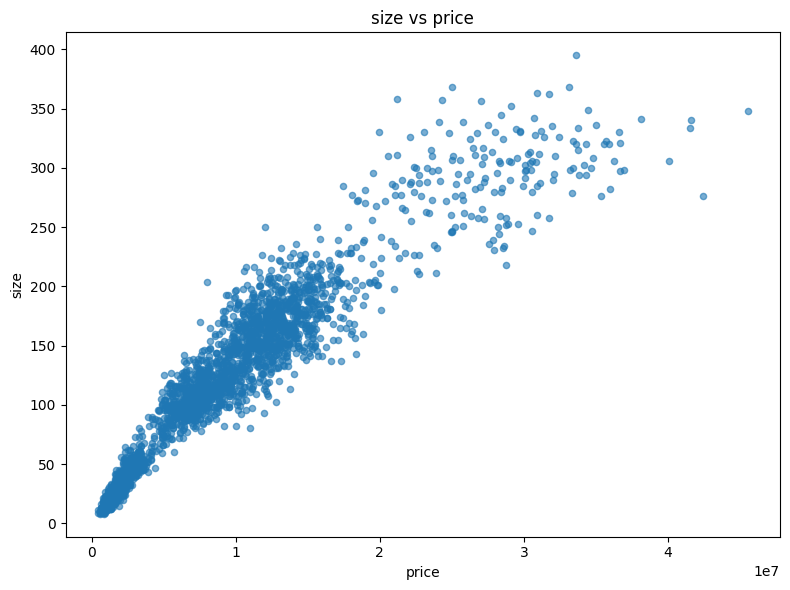

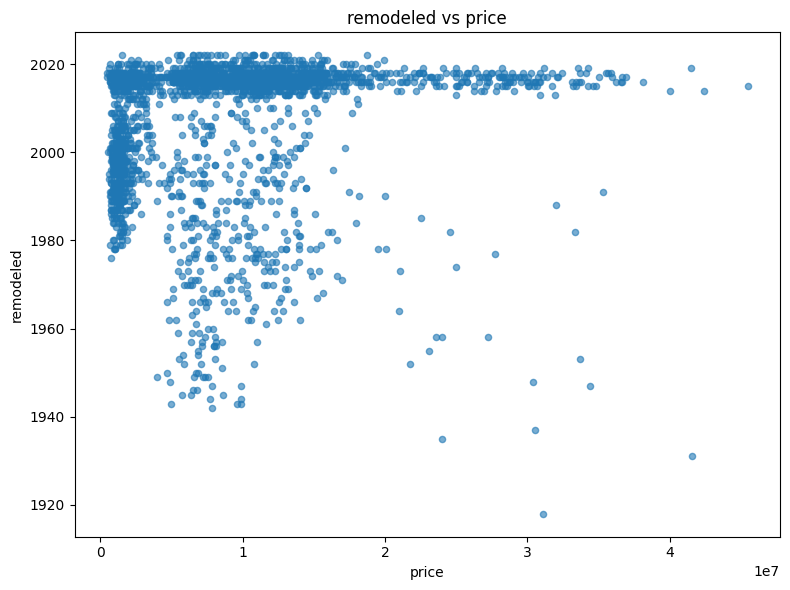

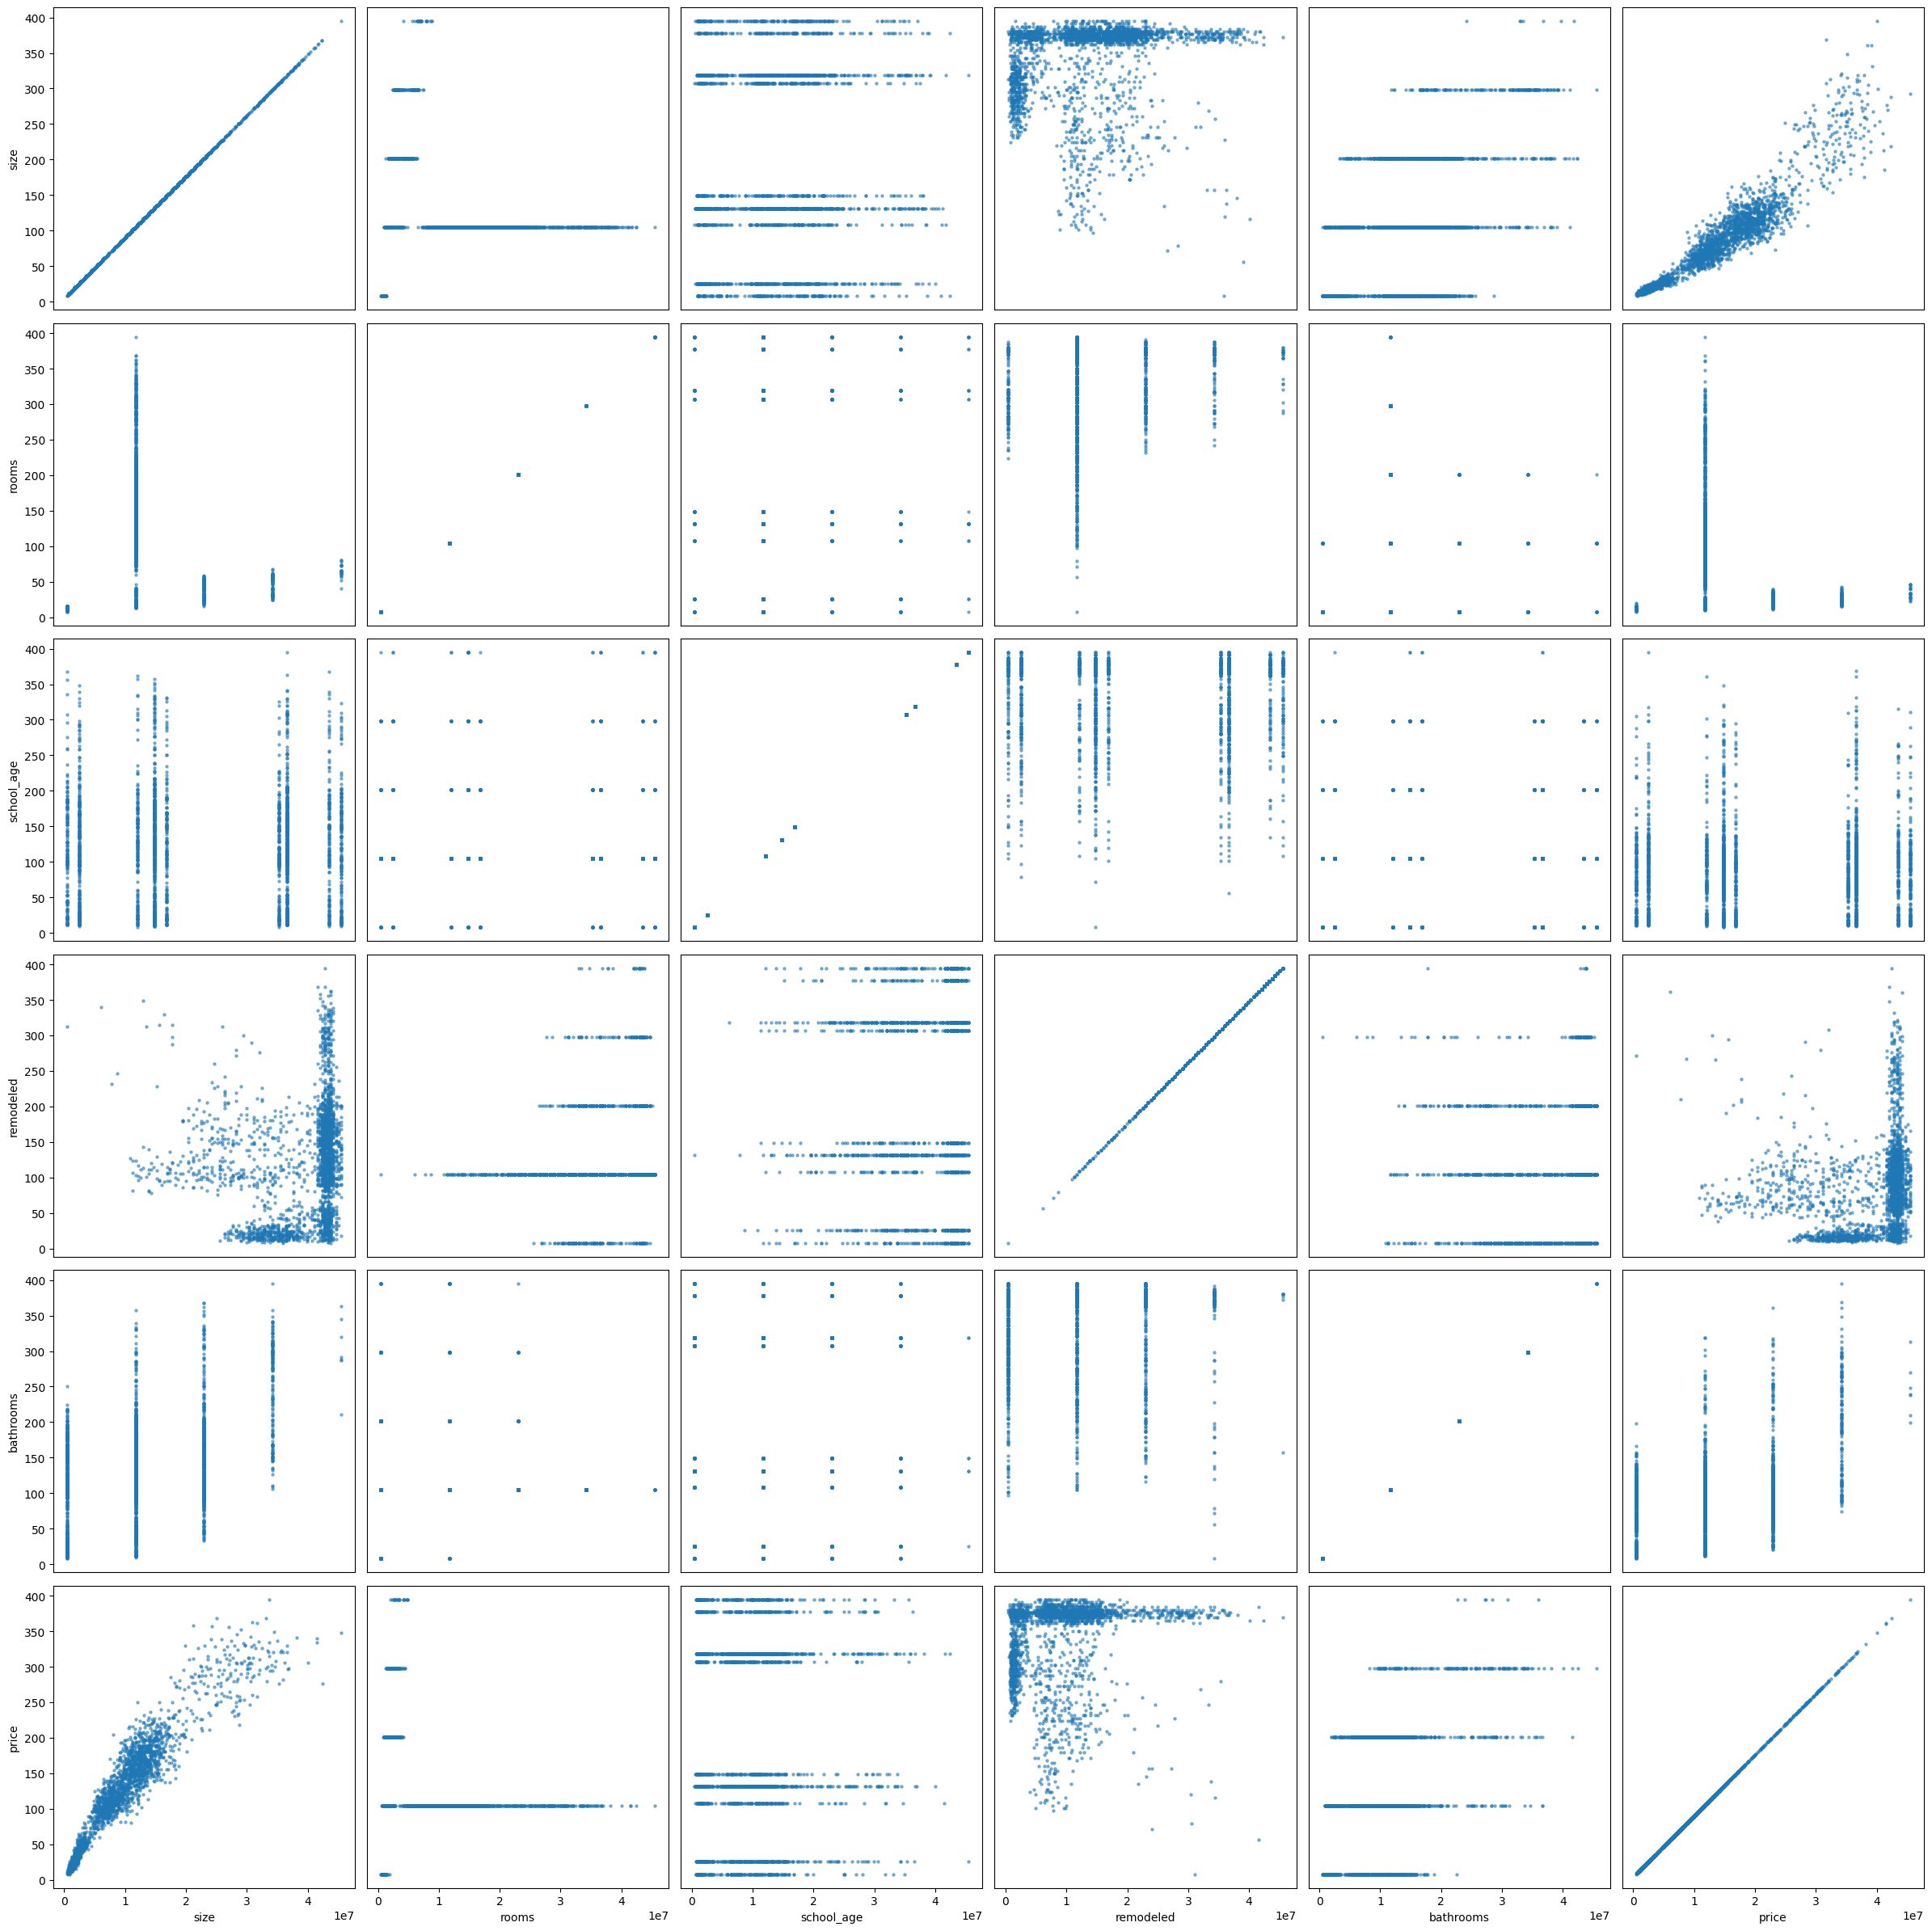

/tmp/ipykernel_40894/196280369.py:86: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



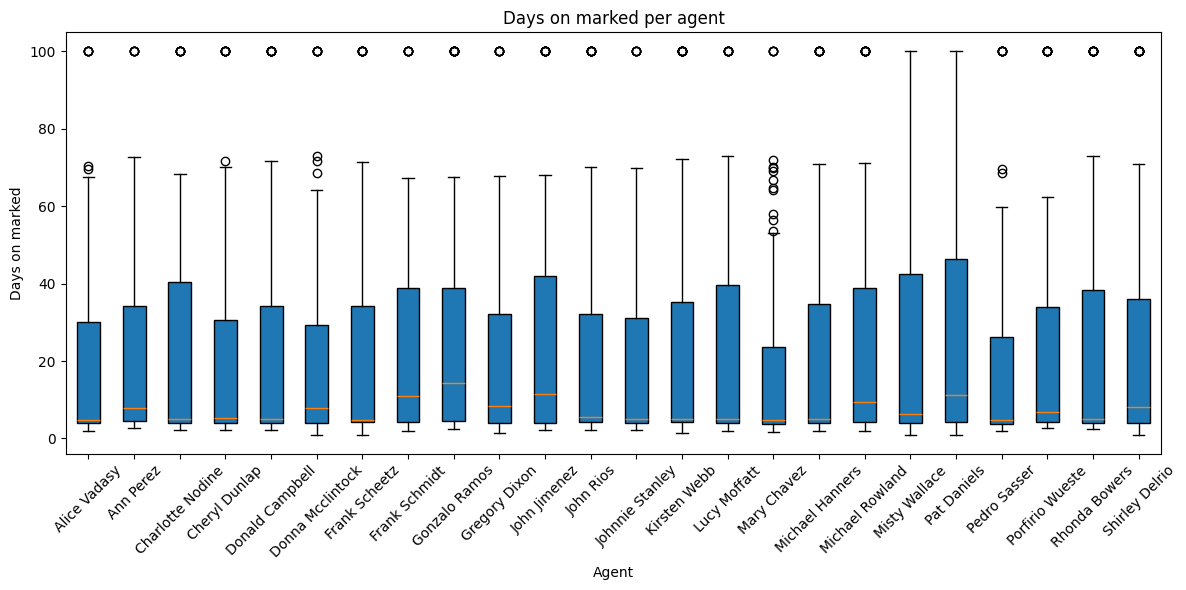

/tmp/ipykernel_40894/196280369.py:110: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



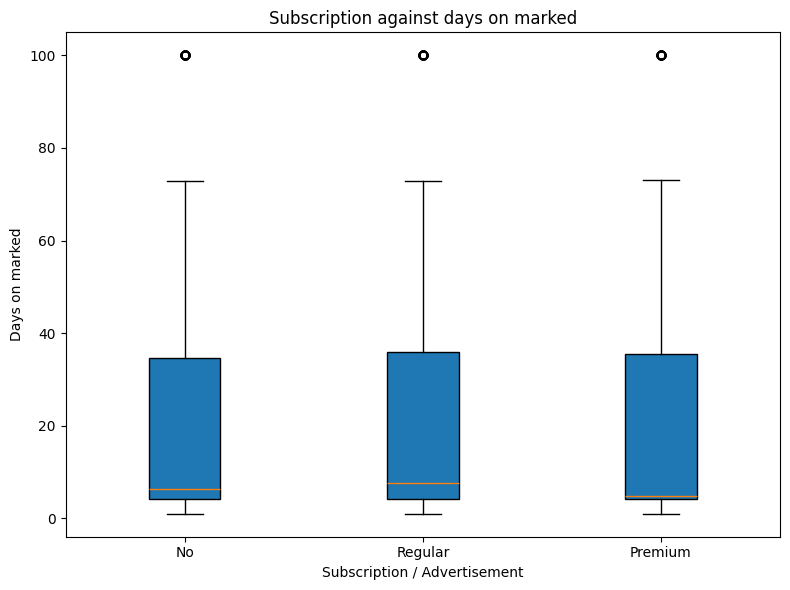

In [239]:
#------------------Plotting section ----------------------------------------
import matplotlib.pyplot as plt
import numpy as np

def plot_continuous_vs_continuous(x_feature, y_feature, df):
    """
    Scatterplot für zwei kontinuierliche Features aus einem dict-basierten DataFrame.
    
    Args:
        x_feature: Name der X-Spalte (numerisch)
        y_feature: Name der Y-Spalte (numerisch)
        df: dict mit Spalten als Keys
    """
    x = np.array(df[x_feature], dtype=float)
    y = np.array(df[y_feature], dtype=float)
    
    # Nur gültige Werte
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    plt.figure(figsize=(8,6))
    plt.scatter(x_clean, y_clean, alpha=0.6, s=20)
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f"{y_feature} vs {x_feature}")
    plt.tight_layout()
    plt.show()

plot_continuous_vs_continuous("price", "size", df)
plot_continuous_vs_continuous("price", "remodeled", df)


# Liste der Features, die du plotten willst
features = [
    "size", "rooms", "bathrooms"
    "year", "school_age", "remodeled",
     "bathrooms", "price"
]

# Filter nur existierende Features
features = [f for f in features if f in df]

n = len(features)
fig, axes = plt.subplots(n, n, figsize=(4*n, 4*n))

for i, fi in enumerate(features):
    x = np.array(df[fi], dtype=float)
    for j, fj in enumerate(features):
        y = np.array(df[fj], dtype=float)
        ax = axes[i,j]
        # nur gültige Werte
        mask = ~np.isnan(x) & ~np.isnan(y)
        ax.scatter(x[mask], y[mask], s=5, alpha=0.5)
        
        if i == n-1:
            ax.set_xlabel(fj)
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(fi)
        else:
            ax.set_yticks([])

plt.tight_layout()
plt.show()

# Alle Agent-Spalten aus df auswählen
agent_cols = [c for c in df.keys() if c.startswith("agent_")]

# Verkaufszeit
days = np.array(df["days_on_market"], dtype=float)

# Für jeden Agenten die Verkaufszeiten sammeln
agent_labels = []
agent_days = []

for col in agent_cols:
    agent_mask = np.array(df[col], dtype=float) == 1  # 1 = dieser Agent
    if np.any(agent_mask):
        agent_days.append(days[agent_mask])
        agent_labels.append(col.replace("agent_", ""))

# Boxplot erstellen
plt.figure(figsize=(12,6))
plt.boxplot(agent_days, labels=agent_labels, patch_artist=True)
plt.xlabel("Agent")
plt.ylabel("Days on marked")
plt.title("Days on marked per agent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Subscription One-Hot Spalten
sub_cols = ["adv_no", "adv_regular", "adv_premium"]
sub_labels = []
sub_days = []

for col in sub_cols:
    if col in df:
        mask = np.array(df[col], dtype=float) == 1
        if np.any(mask):
            sub_days.append(days[mask])
            # Label schöner darstellen
            sub_labels.append(col.replace("adv_", "").capitalize())

# Boxplot erstellen
plt.figure(figsize=(8,6))
plt.boxplot(sub_days, labels=sub_labels, patch_artist=True)
plt.xlabel("Subscription / Advertisement")
plt.ylabel("Days on marked")
plt.title("Subscription against days on marked")
plt.tight_layout()
plt.show()